# Tutorial TGAN

## Time-series Generative Adversarial Networks

```
Title: Time-series Generative Adversarial Networks
Paper Authors: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar
Colab Creator: Derek Snow
```

Mount Google Drive

In [ ]:
## You are advised to save your progress (i.e models), one way of doing it is by 
## ..mounting a drive. This is optional. 

# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
# %cd "/content/drive/My Drive/FirmAI/TSGAN/timegan"

Clone Forked Package

In [1]:

!git clone https://github.com/firmai/tsgan.git
%cd tsgan/alg/timegan

E:\Server_mantain\robotic_arm\tsgan\alg\timegan


Cloning into 'tsgan'...


This tutorial shows how to use TGAN to generate synthetic time-series data. We are using Google Stock and Sine dataset as examples. After you have generated your multi-variate time series data, you need to test how close the generated data is to your original data. I have experimented with a range of transformations, distance metrics and tests in the following [Colab](https://colab.research.google.com/drive/1QSDTKvNiwc1IRCX_VYr9TRFusdX1gLMM?usp=sharing). In this notebook, starting after this code-block you can generate your own data, save it, and use the above notebook to test your data's similarity (aggregates, distribution, fit, correlation, auto-correlation).

Experiment Settings (Import necessary packages and functions)

In [2]:
import numpy as np
import sys

#%% Functions
# 1. Models
from tgan import tgan

# 2. Data Loading
from data_loading import google_data_loading, sine_data_generation

# 3. Metrics
sys.path.append('metrics')
from discriminative_score_metrics import discriminative_score_metrics
from visualization_metrics import PCA_Analysis, tSNE_Analysis
from predictive_score_metrics import predictive_score_metrics

print('Finish importing necessary packages and functions')


Finish importing necessary packages and functions


Code

For TensorFlow 2.0 you have to use ```tf.keras.layer.Dense``` to create a fully connected layer, but more importantly, you have to migrate your codebase to Keras. In fact, you can't define a layer and use it without creating a ```tf.keras.Model``` object that uses it. Currently the code remains in TF1.

In [3]:
'''
2019 NeurIPS Submission
Title: Time-series Generative Adversarial Networks
Authors: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar

Last Updated Date: May 29th 2019
Code Author: Jinsung Yoon (jsyoon0823@gmail.com)

Adapted for Colab by Derek Snow
-----------------------------

TGAN Function
- Use original data as training set to generater synthetic data (time-series)

Inputs
- Dataset
- Network Parameters

Outputs
- time-series synthetic data
'''

#%% Necessary Packages
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

#%% Min Max Normalizer

def MinMaxScaler(dataX):
    
    min_val = np.min(np.min(dataX, axis = 0), axis = 0)
    dataX = dataX - min_val
    
    max_val = np.max(np.max(dataX, axis = 0), axis = 0)
    dataX = dataX / (max_val + 1e-7)
    
    return dataX, min_val, max_val

#%% Start TGAN function (Input: Original data, Output: Synthetic Data)

def tgan (dataX, parameters):
  
    # Initialization on the Graph
    tf.reset_default_graph()

    # Basic Parameters
    No = len(dataX)
    data_dim = len(dataX[0][0,:])
    
    # Maximum seq length and each seq length
    dataT = list()
    Max_Seq_Len = 0
    for i in range(No):
        Max_Seq_Len = max(Max_Seq_Len, len(dataX[i][:,0]))
        dataT.append(len(dataX[i][:,0]))
        
    # Normalization
    if ((np.max(dataX) > 1) | (np.min(dataX) < 0)):
        dataX, min_val, max_val = MinMaxScaler(dataX)
        Normalization_Flag = 1
    else:
        Normalization_Flag = 0
     
    # Network Parameters
    hidden_dim   = parameters['hidden_dim'] 
    num_layers   = parameters['num_layers']
    iterations   = parameters['iterations']
    batch_size   = parameters['batch_size']
    module_name  = parameters['module_name']    # 'lstm' or 'lstmLN'
    z_dim        = parameters['z_dim']
    gamma        = 1
    
    #%% input place holders
    
    X = tf.placeholder(tf.float32, [None, Max_Seq_Len, data_dim], name = "myinput_x")
    Z = tf.placeholder(tf.float32, [None, Max_Seq_Len, z_dim], name = "myinput_z")
    T = tf.placeholder(tf.int32, [None], name = "myinput_t")
    
    #%% Basic RNN Cell
          
    def rnn_cell(module_name):
      # GRU
        if (module_name == 'gru'):
            rnn_cell = tf.nn.rnn_cell.GRUCell(num_units=hidden_dim, activation=tf.nn.tanh)
      # LSTM
        elif (module_name == 'lstm'):
            rnn_cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, activation=tf.nn.tanh)
      # LSTM Layer Normalization
        elif (module_name == 'lstmLN'):
            rnn_cell = tf.contrib.rnn.LayerNormBasicLSTMCell(num_units=hidden_dim, activation=tf.nn.tanh)
        return rnn_cell
      
        
    #%% build a RNN embedding network      
    
    def embedder (X, T):      
      
        with tf.variable_scope("embedder", reuse = tf.AUTO_REUSE):
            
            e_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name) for _ in range(num_layers)])
                
            e_outputs, e_last_states = tf.nn.dynamic_rnn(e_cell, X, dtype=tf.float32, sequence_length = T)
            
            H = tf.contrib.layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     

        return H
      
    ##### Recovery
    
    def recovery (H, T):      
      
        with tf.variable_scope("recovery", reuse = tf.AUTO_REUSE):       
              
            r_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name) for _ in range(num_layers)])
                
            r_outputs, r_last_states = tf.nn.dynamic_rnn(r_cell, H, dtype=tf.float32, sequence_length = T)
            
            X_tilde = tf.contrib.layers.fully_connected(r_outputs, data_dim, activation_fn=tf.nn.sigmoid) 

        return X_tilde
    
    
    
    #%% build a RNN generator network
    
    def generator (Z, T):      
      
        with tf.variable_scope("generator", reuse = tf.AUTO_REUSE):
            
            e_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name) for _ in range(num_layers)])
                
            e_outputs, e_last_states = tf.nn.dynamic_rnn(e_cell, Z, dtype=tf.float32, sequence_length = T)
            
            E = tf.contrib.layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     

        return E
      
    def supervisor (H, T):      
      
        with tf.variable_scope("supervisor", reuse = tf.AUTO_REUSE):
            
            e_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name) for _ in range(num_layers-1)])
                
            e_outputs, e_last_states = tf.nn.dynamic_rnn(e_cell, H, dtype=tf.float32, sequence_length = T)
            
            S = tf.contrib.layers.fully_connected(e_outputs, hidden_dim, activation_fn=tf.nn.sigmoid)     

        return S
      
      
      
    #%% builde a RNN discriminator network 
    
    def discriminator (H, T):
      
        with tf.variable_scope("discriminator", reuse = tf.AUTO_REUSE):
            
            d_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(module_name) for _ in range(num_layers)])
                
            d_outputs, d_last_states = tf.nn.dynamic_rnn(d_cell, H, dtype=tf.float32, sequence_length = T)
            
            Y_hat = tf.contrib.layers.fully_connected(d_outputs, 1, activation_fn=None) 
    
        return Y_hat   
    
    
    #%% Random vector generation
    def random_generator (batch_size, z_dim, T_mb, Max_Seq_Len):
      
        Z_mb = list()
        
        for i in range(batch_size):
            
            Temp = np.zeros([Max_Seq_Len, z_dim])
            
            Temp_Z = np.random.uniform(0., 1, [T_mb[i], z_dim])
        
            Temp[:T_mb[i],:] = Temp_Z
            
            Z_mb.append(Temp_Z)
      
        return Z_mb
    
    #%% Functions
    
    # Embedder Networks
    H = embedder(X, T)
    X_tilde = recovery(H, T)
    
    # Generator
    E_hat = generator(Z, T)
    H_hat = supervisor(E_hat, T)
    H_hat_supervise = supervisor(H, T)
    
    # Synthetic data
    X_hat = recovery(H_hat, T)
    
    # Discriminator
    Y_fake = discriminator(H_hat, T)
    Y_real = discriminator(H, T)     
    Y_fake_e = discriminator(E_hat, T)
    
    # Variables        
    e_vars = [v for v in tf.trainable_variables() if v.name.startswith('embedder')]
    r_vars = [v for v in tf.trainable_variables() if v.name.startswith('recovery')]
    g_vars = [v for v in tf.trainable_variables() if v.name.startswith('generator')]
    s_vars = [v for v in tf.trainable_variables() if v.name.startswith('supervisor')]
    d_vars = [v for v in tf.trainable_variables() if v.name.startswith('discriminator')]
    
    # Loss for the discriminator
    D_loss_real = tf.losses.sigmoid_cross_entropy(tf.ones_like(Y_real), Y_real)
    D_loss_fake = tf.losses.sigmoid_cross_entropy(tf.zeros_like(Y_fake), Y_fake)
    D_loss_fake_e = tf.losses.sigmoid_cross_entropy(tf.zeros_like(Y_fake_e), Y_fake_e)
    D_loss = D_loss_real + D_loss_fake + gamma * D_loss_fake_e
            
    # Loss for the generator
    # 1. Adversarial loss
    G_loss_U = tf.losses.sigmoid_cross_entropy(tf.ones_like(Y_fake), Y_fake)
    G_loss_U_e = tf.losses.sigmoid_cross_entropy(tf.ones_like(Y_fake_e), Y_fake_e)
    
    # 2. Supervised loss
    G_loss_S = tf.losses.mean_squared_error(H[:,1:,:], H_hat_supervise[:,1:,:])
    
    # 3. Two Momments
    G_loss_V1 = tf.reduce_mean(tf.math.abs(tf.sqrt(tf.nn.moments(X_hat,[0])[1] + 1e-6) - tf.sqrt(tf.nn.moments(X,[0])[1] + 1e-6)))
    G_loss_V2 = tf.reduce_mean(tf.math.abs((tf.nn.moments(X_hat,[0])[0]) - (tf.nn.moments(X,[0])[0])))
    
    G_loss_V = G_loss_V1 + G_loss_V2
    
    # Summation
    G_loss = G_loss_U + gamma * G_loss_U_e + 100 * tf.sqrt(G_loss_S) + 100*G_loss_V 
            
    # Loss for the embedder network
    E_loss_T0 = tf.losses.mean_squared_error(X, X_tilde)
    E_loss0 = 10*tf.sqrt(E_loss_T0)
    E_loss = E_loss0  + 0.1*G_loss_S
    
    # optimizer
    E0_solver = tf.train.AdamOptimizer().minimize(E_loss0, var_list = e_vars + r_vars)
    E_solver = tf.train.AdamOptimizer().minimize(E_loss, var_list = e_vars + r_vars)
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list = d_vars)
    G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list = g_vars + s_vars)      
    GS_solver = tf.train.AdamOptimizer().minimize(G_loss_S, var_list = g_vars + s_vars)   
        
    #%% Sessions    
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    #%% Embedding Learning
    
    print('Start Embedding Network Training')
    
    for itt in range(iterations):
        
        # Batch setting
        idx = np.random.permutation(No)
        train_idx = idx[:batch_size]     
            
        X_mb = list(dataX[i] for i in train_idx)
        T_mb = list(dataT[i] for i in train_idx)
            
        # Train embedder        
        _, step_e_loss = sess.run([E0_solver, E_loss_T0], feed_dict={X: X_mb, T: T_mb})
        
        if itt % 1000 == 0:
            print('step: '+ str(itt) + ', e_loss: ' + str(np.round(np.sqrt(step_e_loss),4)) )        
            
    print('Finish Embedding Network Training')
    
    #%% Training Supervised Loss First
    
    print('Start Training with Supervised Loss Only')
    
    for itt in range(iterations):
        
        # Batch setting
        idx = np.random.permutation(No)
        train_idx = idx[:batch_size]     
            
        X_mb = list(dataX[i] for i in train_idx)
        T_mb = list(dataT[i] for i in train_idx)        
        
        Z_mb = random_generator(batch_size, z_dim, T_mb, Max_Seq_Len)
        
        # Train generator       
        _, step_g_loss_s = sess.run([GS_solver, G_loss_S], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})
                           
        if itt % 1000 == 0:
            print('step: '+ str(itt) + ', s_loss: ' + str(np.round(np.sqrt(step_g_loss_s),4)) )
                
    print('Finish Training with Supervised Loss Only')
    
    #%% Joint Training
    
    print('Start Joint Training')
    
    # Training step
    for itt in range(iterations):
      
        # Generator Training
        for kk in range(2):
          
            # Batch setting
            idx = np.random.permutation(No)
            train_idx = idx[:batch_size]     
            
            X_mb = list(dataX[i] for i in train_idx)
            T_mb = list(dataT[i] for i in train_idx)
            
            # Random vector generation
            Z_mb = random_generator(batch_size, z_dim, T_mb, Max_Seq_Len)
              
            # Train generator
            _, step_g_loss_u, step_g_loss_s, step_g_loss_v = sess.run([G_solver, G_loss_U, G_loss_S, G_loss_V], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})
            
            # Train embedder        
            _, step_e_loss_t0 = sess.run([E_solver, E_loss_T0], feed_dict={Z: Z_mb, X: X_mb, T: T_mb})   
           
        #%% Discriminator Training
        
        # Batch setting
        idx = np.random.permutation(No)
        train_idx = idx[:batch_size]     
        
        X_mb = list(dataX[i] for i in train_idx)
        T_mb = list(dataT[i] for i in train_idx)
        
        # Random vector generation
        Z_mb = random_generator(batch_size, z_dim, T_mb, Max_Seq_Len)
            
        
        check_d_loss = sess.run(D_loss, feed_dict={X: X_mb, T: T_mb, Z: Z_mb})
        
        # Train discriminator
        
        if (check_d_loss > 0.15):        
            _, step_d_loss = sess.run([D_solver, D_loss], feed_dict={X: X_mb, T: T_mb, Z: Z_mb})
        
        #%% Checkpoints
        if itt % 1000 == 0:
            print('step: '+ str(itt) + 
                  ', d_loss: ' + str(np.round(step_d_loss,4)) + 
                  ', g_loss_u: ' + str(np.round(step_g_loss_u,4)) + 
                  ', g_loss_s: ' + str(np.round(np.sqrt(step_g_loss_s),4)) + 
                  ', g_loss_v: ' + str(np.round(step_g_loss_v,4)) + 
                  ', e_loss_t0: ' + str(np.round(np.sqrt(step_e_loss_t0),4))  )
   
    
    print('Finish Joint Training')
    
    #%% Final Outputs
    
    Z_mb = random_generator(No, z_dim, dataT, Max_Seq_Len)
    
    X_hat_curr = sess.run(X_hat, feed_dict={Z: Z_mb, X: dataX, T: dataT})    
    
    #%% List of the final outputs
    
    dataX_hat = list()
    
    for i in range(No):
        Temp = X_hat_curr[i,:dataT[i],:]
        dataX_hat.append(Temp)
        
    # Renormalization
    if (Normalization_Flag == 1):
        dataX_hat = dataX_hat * max_val
        dataX_hat = dataX_hat + min_val
    
    return dataX_hat
    

Instructions for updating:
non-resource variables are not supported in the long term


Set main parameters and datasets

In [ ]:
#robotic_arm/Dataset/Task2/RawData/task2_test_1.csv

In [5]:
import pandas as pd


df_list = []
dataX = []
for i in range(1,23):

  print("Read {}th data".format(i))
  df_rawdata = pd.read_csv("E:/Server_mantain/robotic_arm/Dataset/Task2/RawData/task2_test_{}.csv".format(i),
                        skiprows=[i for i in range(10)],
                        index_col='TimeStamp'
                        )
  #print(df_rawdata.columns)
  Data_Col = df_rawdata.columns
  df_list.append(df_rawdata.iloc[:6236,:])
  dataX.append(df_rawdata.values[:6236,:])

Read 1th data
Read 2th data
Read 3th data
Read 4th data
Read 5th data
Read 6th data
Read 7th data
Read 8th data
Read 9th data
Read 10th data
Read 11th data
Read 12th data
Read 13th data
Read 14th data
Read 15th data
Read 16th data
Read 17th data
Read 18th data
Read 19th data
Read 20th data
Read 21th data
Read 22th data


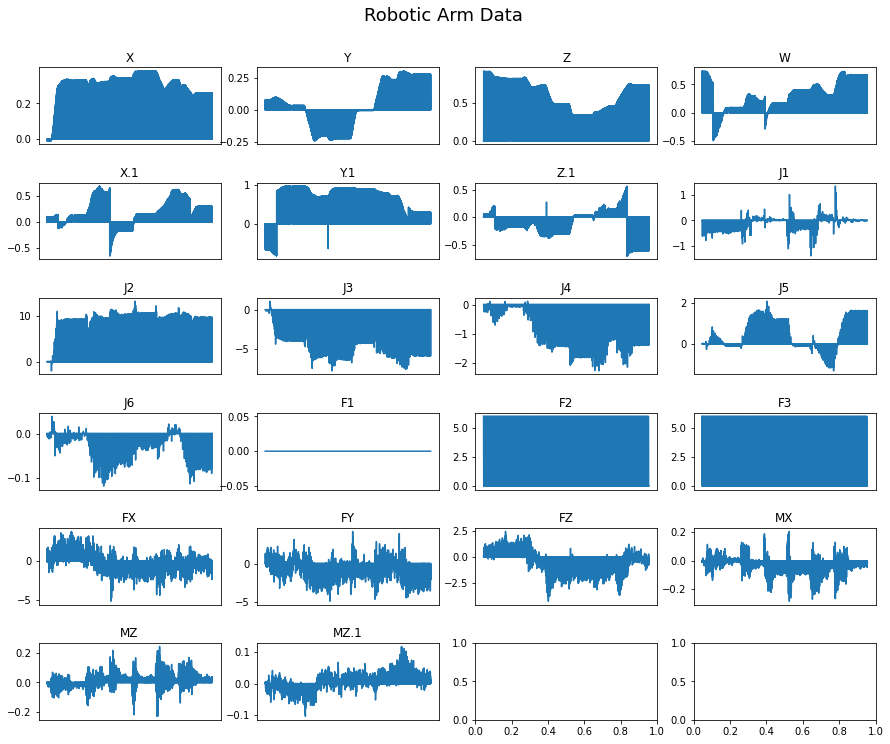

In [6]:
## The settings are now pre-configured to use the Google dataset
#%% Main Parameters
# Data
data_set = ['google','sine']
data_name = data_set[1]
import matplotlib.pyplot as plt


# Experiments iterations
Iteration = 2
Sub_Iteration = 3

#%% Data Loading
seq_length = 25

"""
if data_name == 'google':
    dataX = google_data_loading(seq_length)
elif data_name == 'sine':
    No = 10000
    F_No = 5
    dataX = sine_data_generation(No, seq_length, F_No)

print(data_name + ' dataset is ready.')
print(dataX[0].shape)
"""

fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Robotic Arm Data", fontsize=18, y=0.95)

# loop through tickers and axes
for ticker, ax in zip(Data_Col, axs.ravel()):
    # filter df for ticker and plot on specified axes
    df_list[0][ticker].plot(ax=ax)

    # chart formatting
    ax.set_title(ticker.upper())
    #ax.get_legend().remove()
    ax.set_xticks([])
    ax.set_xlabel("")

plt.show()




Set network parameters & Output initialization

In [7]:
  #%% Newtork Parameters
parameters = dict()

parameters['hidden_dim'] = len(dataX[0][0,:]) * 4
parameters['num_layers'] = 3
#parameters['iterations'] = 10000
#parameters['iterations'] = 100 # first
#parameters['iterations'] = 500 # second
parameters['iterations'] = 10 ## Fast Experimentation (please change appropriately)
parameters['batch_size'] = 10
parameters['module_name'] = 'gru'   # Other options: 'lstm' or 'lstmLN'
parameters['z_dim'] = len(dataX[0][0,:]) 

print('Parameters are ' + str(parameters))

#%% Experiments
# Output Initialization
Discriminative_Score = list()
Predictive_Score = list()

Parameters are {'hidden_dim': 88, 'num_layers': 3, 'iterations': 10, 'batch_size': 10, 'module_name': 'gru', 'z_dim': 22}


Run TGAN & Evaluate discriminative and predictive scores

In [8]:
print('Start iterations') 
## If you want to renormalise the data, you have to use the flag - Normalization_Flag

    
# Each Iteration
for it in range(Iteration):

    
    # Synthetic Data Generation
    dataX_hat = tgan(dataX, parameters)   
      
    print('Finish Synthetic Data Generation')

    #%% Performance Metrics
    
    # 1. Discriminative Score
    Acc = list()
    for tt in range(Sub_Iteration):
        Temp_Disc = discriminative_score_metrics (dataX, dataX_hat)
        Acc.append(Temp_Disc)
    
    Discriminative_Score.append(np.mean(Acc))
    
    # 2. Predictive Performance
    MAE_All = list()
    for tt in range(Sub_Iteration):
        MAE_All.append(predictive_score_metrics (dataX, dataX_hat))
        
    Predictive_Score.append(np.mean(MAE_All))    
    
print('Finish TGAN iterations')

Start iterations
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\user\AppData\Local\Temp/ipykernel_116640/3965311912.py:86: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  rnn_cell = tf.nn.rnn_cell.GRUCell(num_units=hidden_dim, activation=tf.nn.tanh)
C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:570: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_kernel = self.add_variable(
C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:574: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._gate_bias = self.add_variable(
C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\keras\layers\legacy_rnn\rnn_cell_impl.py:580: Us

AttributeError: module 'tensorflow.compat.v1' has no attribute 'contrib'

In [ ]:
import pickle
import numpy as np
# You can check in again 
def scale_array(arr):
  x_min = arr.min(axis=(1, 2), keepdims=True)
  x_max = arr.max(axis=(1, 2), keepdims=True)
  arr = (arr - x_min)/(x_max-x_min)
  return arr

def load_data(file_name="pickle.p"):
  arr = pickle.load(open(file_name, "rb"))
  arr = np.stack(arr)
  arr = scale_array(arr)
  shape_arr = arr.shape
  shape_text = "{}, shape: samples={}, steps={}, features={}".format(file_name,*shape_arr)
  
  print(shape_text)
  return arr


In [ ]:
# Only valid with a mounted drive. 
# import pickle
# pickle.dump(dataX_hat, open( "generated_ts_1.p", "wb" ) )
# pickle.dump(dataX, open( "original_ts.p", "wb" ) )

# The order of the data is original, thorough generation (potentially more similar), ..
# ..short generation (potentially less similar)
# org = load_data("original_ts.p")
# gen_1 = load_data("generated_ts_1.p") ## went for 500 iterations
# gen_2 = load_data("generated_ts_2.p") ## went for 100 iterations

Only use this data, if you don't want to wait to generate your own above, otherwise, skip this code block.

In [ ]:
import cloudpickle as cp
from urllib.request import urlopen
dataX = cp.load(urlopen("https://github.com/firmai/tsgan/blob/master/alg/timegan/gendata/original_ts.p?raw=true")) ##(100 iterations)
dataX_hat = cp.load(urlopen("https://github.com/firmai/tsgan/blob/master/alg/timegan/gendata/generated_ts_1.p?raw=true")) ##(500 iterations)
dataX_hat_2 = cp.load(urlopen("https://github.com/firmai/tsgan/blob/master/alg/timegan/gendata/generated_ts_2.p?raw=true")) ##(100 iterations)


In [ ]:
# Basic Parameters
No = len(dataX)
data_dim = len(dataX[0][0,:])

# Compute Maximum seq length and each seq length
dataT = list()
Max_Seq_Len = 0
for i in range(No):
    Max_Seq_Len = max(Max_Seq_Len, len(dataX[i][:,0]))
    dataT.append(len(dataX[i][:,0]))

def train_test_divide (dataX, dataX_hat, dataT):
  
    # Divide train/test index
    No = len(dataX)
    idx = np.random.permutation(No)
    train_idx = idx[:int(No*0.8)]
    test_idx = idx[int(No*0.8):]
    
    # Train and Test X
    trainX = [dataX[i] for i in train_idx]
    trainX_hat = [dataX_hat[i] for i in train_idx]
    
    testX = [dataX[i] for i in test_idx]
    testX_hat = [dataX_hat[i] for i in test_idx]
    
    # Train and Test T
    trainT = [dataT[i] for i in train_idx]
    testT = [dataT[i] for i in test_idx]
  
    return trainX, trainX_hat, testX, testX_hat, trainT, testT
    
# Train / Test Division
trainX, trainX_hat, testX, testX_hat, trainT, testT = train_test_divide (dataX, dataX_hat, dataT)

Visualization (PCA Analysis)

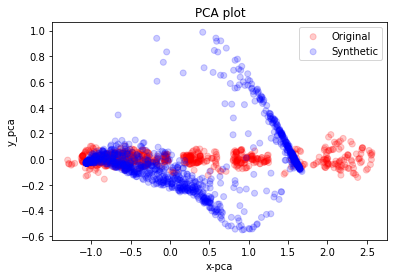

In [ ]:
PCA_Analysis(dataX, dataX_hat)

Visualization (t-SNE Analysis)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.005s...
[t-SNE] Computed neighbors for 2000 samples in 0.098s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.027531
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.153831
[t-SNE] KL divergence after 300 iterations: 0.727049


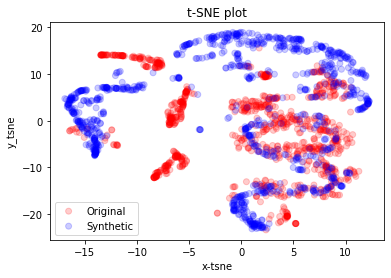

In [ ]:
tSNE_Analysis(dataX, dataX_hat)

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt
import sklearn as sk
import pandas as pd

def recurrence_plot(s, eps=None, steps=None):
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = sk.metrics.pairwise.pairwise_distances(s)
    d = np.floor(d / eps)
    d[d > steps] = steps
    #Z = squareform(d)
    return d


newarray = np.dstack(dataX)
newarray = newarray.mean(axis=2)
real_df = pd.DataFrame(newarray); real_df.head()

,0,1,2,3,4,5
0,0.332789,0.334682,0.336073,0.333233,0.333233,0.088942
1,0.332534,0.334426,0.335815,0.332978,0.332978,0.088965
2,0.332277,0.334170,0.335555,0.332721,0.332721,0.088986
3,0.332019,0.333912,0.335294,0.332464,0.332464,0.089018
4,0.331762,0.333653,0.335033,0.332205,0.332205,0.089047


Recurrence Plots

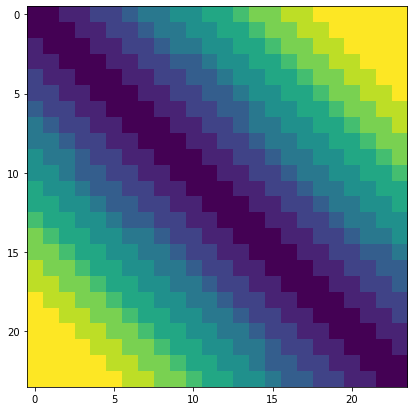

In [ ]:
## Does seem to take all the values in to account 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,14))
ax = fig.add_subplot(1, 2, 2)
ax.imshow(recurrence_plot(newarray,0.001))
    

In [ ]:
import pandas as pd
newarray_gen = np.dstack(dataX_hat)
newarray_gen = newarray_gen.mean(axis=2)
fake_df = pd.DataFrame(newarray_gen); fake_df.head()


,0,1,2,3,4,5
0,0.379898,0.379363,0.382255,0.380587,0.381812,0.113793
1,0.351299,0.352439,0.355653,0.345863,0.348911,0.121244
2,0.358892,0.361680,0.361088,0.356695,0.362021,0.086519
3,0.356329,0.360158,0.357267,0.354473,0.356844,0.082524
4,0.355124,0.358488,0.356185,0.354370,0.354718,0.079493


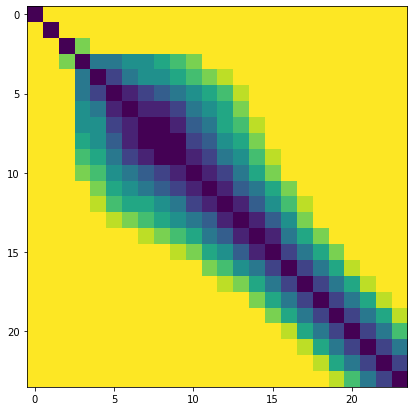

In [ ]:
## Does seem to take all the values in to account 
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,14))
ax = fig.add_subplot(1, 2, 2)
ax.imshow(recurrence_plot(newarray_gen,0.001))
  

In [ ]:
diffs = pd.DataFrame(real_df-fake_df); diffs.head()

,0,1,2,3,4,5
0,-0.006896,-0.001698,-0.010295,-0.004992,-0.000087,0.018735
1,0.028039,0.007941,0.014853,0.019870,0.027117,0.055140
2,0.024614,0.021032,0.037205,0.024974,0.031501,0.050543
3,0.022666,0.028007,0.024181,0.023683,0.022621,0.043545
4,0.024267,0.028920,0.023918,0.032825,0.026182,0.034904


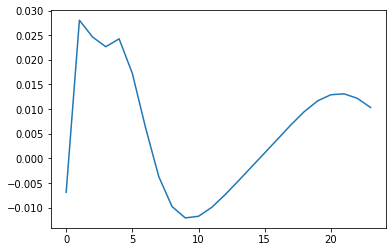

In [ ]:
diffs[0].plot()

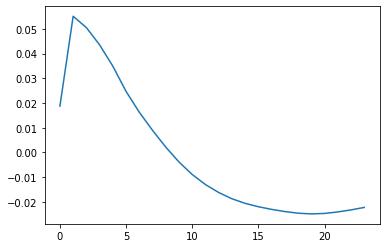

In [ ]:
diffs[5].plot()

In [ ]:
fake_df.corr()

,0,1,2,3,4,5
0,1.000000,0.921732,0.961889,0.956579,0.973921,0.364166
1,0.921732,1.000000,0.943739,0.940208,0.899829,0.228233
2,0.961889,0.943739,1.000000,0.945899,0.962571,0.355501
3,0.956579,0.940208,0.945899,1.000000,0.970825,0.488641
4,0.973921,0.899829,0.962571,0.970825,1.000000,0.516457
5,0.364166,0.228233,0.355501,0.488641,0.516457,1.000000


In [ ]:
real_df.corr()

,0,1,2,3,4,5
0,1.000000,0.999998,0.999998,0.999997,0.999997,-0.989726
1,0.999998,1.000000,0.999999,0.999999,0.999999,-0.989820
2,0.999998,0.999999,1.000000,0.999999,0.999999,-0.989880
3,0.999997,0.999999,0.999999,1.000000,1.000000,-0.989929
4,0.999997,0.999999,0.999999,1.000000,1.000000,-0.989929
5,-0.989726,-0.989820,-0.989880,-0.989929,-0.989929,1.000000


For further similarity and measures and visualisations see this [Colab](https://colab.research.google.com/drive/1QmadgT9cZ-Bz4nIwHhknLfMNKCBwaI1_?usp=sharing) notebook.